# **Recover the transverse momentum broadening from correlators of Lorentz forces**

## Default simulation parameters for the Glasma and the Wong solvers

In [1]:
import numpy as np

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# General parameters
su_group = 'su3'        # Gauge group
representation = 'fundamental'      # Fundamental or adjoint representation
boundary = 'periodic'        # Periodic boundary conditions or frozen dynamics at boundary

# Simulation box parameters
L = 10      # Length of simulation box [fm]
N = 512     # Number of lattice sites
tau_sim = 0.5     # Simulation time [fm/c]
DTS = 8     # Time step

# MV model parameters
Qs = 2              # Saturation momentum [GeV]	
ns = 50     # Number of color sheets
factor = 0.8        # Ratio between Qs/g^2\mu for Ns = 50 color sheets
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))           # Running coupling constant		
mu = Qs / (g**2 * factor)           # MV model parameter	
ir = 0.1 * g**2 * mu         # Infrared regulator [GeV]
uv = 10.0           # Ultraviolet regulator [GeV]

# Heavy quark related parameters, chosen here for a charm quark
quark = 'massive'     # Quark type
mass = 1000      # Heavy quark mass [GeV]
tau_form = 1/(2*mass)*hbarc     # Formation time [fm/c]
pT = 0.5    # Initial transverse momentum [GeV]
ntp = 100000   # Number of test particles

# Other numerical parameters
nevents = 1    # Number of Glasma events

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,       
    'PT': pT,          
    }

## Set environment variables and import all relevant modules

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group
os.environ["REPRESENTATION"] = representation
os.environ["BOUNDARY"] = boundary

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
from curraun.fields_correlators import FieldsCorrelators
# Wong modules
from curraun import wong
wong.DEBUG = False
from curraun.wong import init_charge
from curraun.wong_correlators import ForceCorrelators
import curraun.kappa_wong as kappa_wong
import curraun.kappa as kappa

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

Using CUDA
Using SU(3)
Using double precision
Using double precision


# Method 1: momentum broadening from post processing
## Run the Wong solver, store the Lorentz forces and Wilson lines

In [3]:
from tqdm import tqdm

# Derived parameters
a = L / N
E0 = N / L * hbarc
DT = 1.0 / DTS
formt = int(p['TFORM'] / a * DTS)
maxt = int(tau_sim / a * DTS)

# Initialize Glasma fields
s = core.Simulation(N, DT, g)
va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
initial.init(s, va, vb)

# Initialize the Wong solver
wong_solver = wong.WongSolver(s, ntp)
pT = p['PT'] / E0
x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 4)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
mass = p['MASS'] / E0 
m = mass * np.ones(ntp)
fcorr = ForceCorrelators(s, wong_solver, ntp)

for i in range(ntp):
    # Positions
    xT = np.random.rand(2) * s.n
    x0 = [xT[0], xT[1], 0.0]
    # Momenta
    angle = 2*np.pi*np.random.rand(1)
    p0 = [0.0, pT * np.cos(angle), pT * np.sin(angle), 0.0]
    # Charges
    q0 = init_charge()

    x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

wong_solver.initialize(x0s, p0s, q0s, m)

ws, fs = np.zeros((maxt-formt, ntp, su.GROUP_ELEMENTS)), np.zeros((maxt-formt, ntp, 3, su.GROUP_ELEMENTS))
sigmapt_avg = np.zeros(maxt-formt)

with tqdm(total=maxt) as pbar:
    for t in range(maxt):
        # Evolve Glasma fields
        core.evolve_leapfrog(s)

        # Solve Wong's equations
        if t>=formt:  
            wong_solver.evolve()
            
            # Store the Lorentz forces and Wilson lines
            fcorr.compute_lorentz_force()
            fs[t-formt] = fcorr.f.copy()
            ws[t-formt] = wong_solver.w.copy()
           
            # Compute the momentum broadening
            if t==formt:
                pmu0 = wong_solver.p.copy()
                px0, py0 = pmu0[:, 1], pmu0[:, 2]
            pmu = wong_solver.p.copy()
            px, py = pmu[:, 1], pmu[:, 2]
            sigmapt = (px-px0)**2 + (py-py0)**2
            sigmapt_avg[t-formt] = np.mean(sigmapt) * E0**2

        pbar.update(1)

100%|██████████| 204/204 [01:41<00:00,  2.00it/s]


## Version 1 
Compute the trace of the autocorrelation function $\mathrm{Tr}\{ F_i(\tau_n) W(\tau_n, \tau_m) F_i(\tau_m) W^\dagger(\tau_n, \tau_m)\rangle \}$, where the appropriate Wilson lines are inserted, and afterwards recover the momentum broadening as $\langle p_i^2\rangle(\tau) = g^2\sum\limits_{\tau_n}^{\tau}\sum\limits_{\tau_m}^{\tau} (\delta\tau)^2 \langle \mathrm{Tr}\{F_i(\tau_n) W(\tau_n, \tau_m) F_i(\tau_m) W^\dagger(\tau_n, \tau_m)\}\rangle$. Here, the Lorentz forces $F_i(\tau_n)\equiv F_i\big(x_T(\tau_n))\big)$ are evaluated along the particle's trajectory and the Wilson lines $W(\tau_n,\tau_m)\equiv W\big(x_T(\tau_n), x_T(\tau_m))\big)$ are computed as $W(\tau_n,\tau_m)=U(\tau_m)U^\dagger(\tau_n)$, in which $U(\tau_n)\equiv U\big(x_T(\tau_n)\big)$ are the Wilson lines used in solving the rotation of the color charge.

In [4]:
autocorr = np.zeros(((maxt-formt)//DTS+1, ntp, 3))
# Set the time step to the numerical one used in the leapfrog solver
dt = 1/DTS

tau_autocorr = []
for tau in range(formt, maxt, DTS):
    tau_autocorr.append(tau)
    tau_step = round((tau-formt)/DTS)
    autocorr_tau = 0
    for tau_n in range(formt, tau, DTS):
        for tau_m in range(formt, tau, DTS):
            fcorr.compute_lorentz_force_autocorrelator(fs[tau_n, :, :, :], fs[tau_m, :, :, :], ws[tau_n, :, :], ws[tau_m, :, :])
            ftau_n_ftau_m = fcorr.auto_corr.copy().real
            # autocorr_tau += ftau_n_ftau_m * dt**2
            autocorr_tau += ftau_n_ftau_m
    autocorr[tau_step] = autocorr_tau

autocorr_avg = np.mean(autocorr, axis=1)
autocorr_T = (autocorr_avg[:,0]+autocorr_avg[:,1])* E0**2

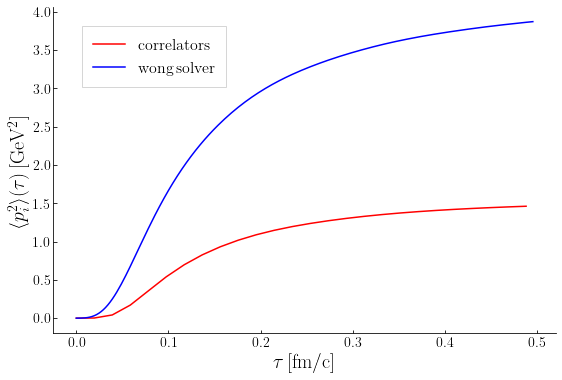

In [5]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
plt.ylabel(r'$\langle p_i^2\rangle(\tau)\,\mathrm{[GeV^2]}$', size = 20)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(direction='in')

tau_corr = np.multiply(tau_autocorr, a/DTS)
ax.plot(tau_corr, autocorr_T, color='r')
tau = np.multiply(range(formt, maxt, 1), a/DTS)
ax.plot(tau, sigmapt_avg, color='b')

lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [r'$\mathrm{correlators}$', r'$\mathrm{wong\,solver}$'], loc = 'upper right', ncol=1, bbox_to_anchor=(0.35,0.95), fontsize='16')
legend1.get_frame().set_boxstyle('square')
legend1.get_title().set_fontsize('18')

fig.patch.set_facecolor('white')

## Version 2
The momentum broadening at a certain time $\langle p_i^2\rangle(\tau) = \sum\limits_{\tau^\prime}^\tau\sum\limits_{\tau^{\prime\prime}}^\tau\delta\tau^\prime\delta\tau^{\prime\prime}\langle F_i(\tau^\prime)F_i(\tau^{\prime\prime})\rangle_{W}$ may be used to express the momentum broadening at the next time as $\langle p_i^2\rangle(\tau+\delta\tau)=\langle p_i^2\rangle(\tau)+2\sum\limits_{\tau^\prime}^\tau \delta\tau^\prime\langle F_i(\tau^\prime)F_i(\tau+\delta\tau)\rangle_W + \langle F_i(\tau+\delta\tau)F_i(\tau+\delta\tau)\rangle_W$, where $\langle FF\rangle_W$ denotes the correlator of Lorentz force transported with the appropriate Wilson lines $W$.

In [6]:
autocorr = np.zeros(((maxt-formt)//DTS+1, ntp, 3))

for t in range(formt, maxt, DTS):
    sumprime = 0
    for tprime in range(formt, t, DTS):
        fcorr.compute_lorentz_force_autocorrelator(fs[(t-formt), :, :, :], fs[(tprime-formt), :, :, :], ws[(t-formt), :, :], ws[(tprime-formt), :, :])
        ftprimeftnplus = fcorr.auto_corr.copy().real
        sumprime += ftprimeftnplus
    fcorr.compute_lorentz_force_autocorrelator(fs[(t-formt), :, :, :], fs[(t-formt), :, :, :], ws[(t-formt), :, :], ws[(t-formt), :, :])
    ftnplusftnplus = fcorr.auto_corr.copy().real
    autocorr[(t-formt)//DTS] += autocorr[(t-formt)//DTS-1] + (2*sumprime + ftnplusftnplus) 

autocorr_avg = np.mean(autocorr, axis=1)
autocorr_T = np.multiply((autocorr_avg[:,0]+autocorr_avg[:,1]), E0**2)

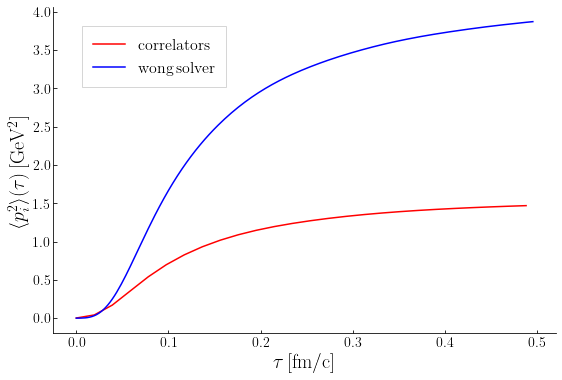

In [8]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
plt.ylabel(r'$\langle p_i^2\rangle(\tau)\,\mathrm{[GeV^2]}$', size = 20)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(direction='in')

tau_corr = np.multiply(range(formt, maxt,DTS), a/DTS)
ax.plot(tau_corr, autocorr_T, color='r')
tau = np.multiply(range(formt, maxt, 1), a/DTS)
ax.plot(tau, sigmapt_avg, color='b')

lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [r'$\mathrm{correlators}$', r'$\mathrm{wong\,solver}$'], loc = 'upper right', ncol=1, bbox_to_anchor=(0.35,0.95), fontsize='16')
legend1.get_frame().set_boxstyle('square')
legend1.get_title().set_fontsize('18')

fig.patch.set_facecolor('white')

# Method 2: momentum broadening from `kappa_wong.py`
## Compute momentum broadening similarly as in `kappa.py` but with Lorentz forces along the trajectories

In [9]:
from tqdm import tqdm

# Derived parameters
a = L / N
E0 = N / L * hbarc
DT = 1.0 / DTS
formt = int(p['TFORM'] / a * DTS)
maxt = int(tau_sim / a * DTS)

# Initialize Glasma fields
s = core.Simulation(N, DT, g)
va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
initial.init(s, va, vb)

# Initialize the Wong solver
wong_solver = wong.WongSolver(s, ntp)
pT = p['PT'] / E0
x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 4)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
mass = p['MASS'] / E0 
m = mass * np.ones(ntp)

for i in range(ntp):
    # Positions
    xT = np.random.rand(2) * s.n
    x0 = [xT[0], xT[1], 0.0]
    # Momenta
    angle = 2*np.pi*np.random.rand(1)
    p0 = [0.0, pT * np.cos(angle), pT * np.sin(angle), 0.0]
    # Charges
    q0 = init_charge()

    x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

wong_solver.initialize(x0s, p0s, q0s, m)

kappa_wong_tforce = kappa_wong.TransportedForce(s, wong_solver, ntp)
kappawongpt, tau =  [], []

kappa_tforce = kappa.TransportedForce(s)
kappapt =  []

if use_cuda:
    s.copy_to_device()
    kappa_tforce.copy_to_device()
    kappa_wong_tforce.copy_to_device()

sigmapt_avg = np.zeros(maxt-formt)
# ps = np.zeros((maxt-formt, ntp, 4))

with tqdm(total=maxt) as pbar:
    for t in range(maxt):
        # Evolve Glasma fields
        core.evolve_leapfrog(s)

        # Solve Wong's equations
        if t>=formt:  
            if t % DTS == 0:
                if use_cuda:
                    kappa_wong_tforce.copy_mean_to_host()
                    kappa_tforce.copy_mean_to_host()

                px_kappa, py_kappa = kappa_wong_tforce.p_perp_mean[0], kappa_wong_tforce.p_perp_mean[1]
                kappawongpt.append((px_kappa + py_kappa) * E0 ** 2)
                tau.append(t*a/DTS)

                px_kappa, py_kappa = kappa_tforce.p_perp_mean[0], kappa_tforce.p_perp_mean[1]
                kappapt.append((px_kappa + py_kappa) * E0 ** 2)
                
                if use_cuda:
                    kappa_wong_tforce.copy_mean_to_device()
                    kappa_tforce.copy_mean_to_device()

            kappa_wong_tforce.compute(wong_solver)
            kappa_tforce.compute()

            wong_solver.evolve()

            if t==formt:
                pmu0 = wong_solver.p.copy()
                px0, py0 = pmu0[:, 1], pmu0[:, 2]
            pmu = wong_solver.p.copy()
            px, py = pmu[:, 1], pmu[:, 2]
            sigmapt = (px-px0)**2 + (py-py0)**2
            sigmapt_avg[t-formt] = np.mean(sigmapt) * E0**2
            # ps[t-formt] = wong_solver.p.copy()

        pbar.update(1)

100%|██████████| 204/204 [00:21<00:00,  9.70it/s]


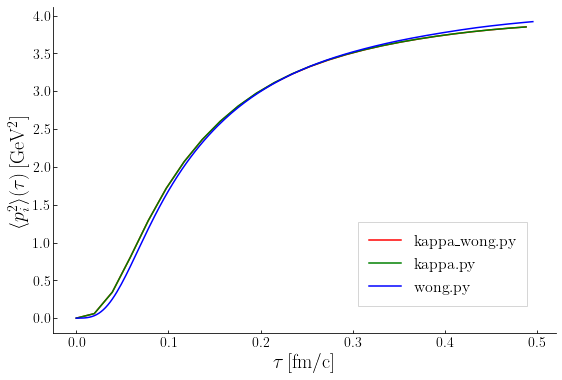

In [10]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
plt.ylabel(r'$\langle p_i^2\rangle(\tau)\,\mathrm{[GeV^2]}$', size = 20)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(direction='in')

ax.plot(tau, kappawongpt, color='r')
ax.plot(tau, kappapt, color='g')
tau_sigmapt = np.multiply(range(formt, maxt, 1), a/DTS)
ax.plot(tau_sigmapt, sigmapt_avg, color='b')

lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1, 2]], [r'$\mathrm{kappa\_wong.py}$', r'$\mathrm{kappa.py}$', r'$\mathrm{wong.py}$'], loc = 'upper right', ncol=1, bbox_to_anchor=(0.95,0.35), fontsize='16')
legend1.get_frame().set_boxstyle('square')
legend1.get_title().set_fontsize('18')

fig.patch.set_facecolor('white')